# Transfer Learning을 활용한 개-고양이 분류 프로젝트

이 노트북은 사전학습된 VGG19 모델을 사용하여 개와 고양이 이미지를 분류하는 Transfer Learning 프로젝트입니다.

## 프로젝트 개요
- **목표**: VGG19 사전학습 모델을 활용한 개-고양이 이진 분류
- **방법**: Transfer Learning (특성 추출 방식)
- **데이터**: Cats and Dogs 데이터셋
- **프레임워크**: TensorFlow/Keras

## Transfer Learning이란?
이미 수십만 장의 이미지로 학습된 모델(VGG19)을 재활용하여:
- **학습 시간 단축**: CNN 부분은 동결하고 분류층만 학습
- **높은 성능**: 적은 데이터로도 좋은 성능 달성
- **효율성**: 컴퓨터 자원이 적어도 학습 가능

## 두 가지 Transfer Learning 방식

### 1. 투스테이지 방식 (Two-Stage)
- **방법**: VGG19의 특징을 미리 계산하고 numpy 배열로 저장 → 분류 학습
- **장점**: 훈련 속도가 매우 빠름
- **단점**: 메모리 사용량 많음, 데이터 증강 제한적

### 2. 인라인 방식 (Inline)  
- **방법**: VGG19 특징 추출부를 전체 모델에 포함하여 학습
- **장점**: 원본 이미지에 데이터 증강 직접 적용, 과적합 방지
- **단점**: 투스테이지보다 속도 느림

**이 프로젝트에서는 투스테이지 방식을 사용합니다.**


## 1. 라이브러리 임포트 및 환경 설정

필요한 라이브러리들을 임포트합니다.


In [2]:
# 딥러닝 관련 라이브러리
import tensorflow as tf
import keras
from keras.applications.vgg19 import VGG19
from keras import models, layers

# 데이터 처리 및 시각화 라이브러리
import matplotlib.pyplot as plt
import numpy as np
import pickle

# 파일 시스템 관련 라이브러리
import os
import shutil
import pathlib
import gdown  # 구글 드라이브에서 데이터 다운로드용

print("라이브러리 임포트 완료!")
print(f"TensorFlow 버전: {tf.__version__}")
print(f"Keras 버전: {keras.__version__}")

# 경고 메시지 제거 (선택사항)
import warnings
warnings.filterwarnings('ignore')


라이브러리 임포트 완료!
TensorFlow 버전: 2.15.1
Keras 버전: 2.15.0


In [3]:
# ✅ GPU/CPU 디바이스 자동 선택
import os
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        DEVICE = '/GPU:0'
        print(f"✅ GPU({tf.test.gpu_device_name()}) 사용 설정 완료")
    except RuntimeError as e:
        print(e)
        DEVICE = '/GPU:0'
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # GPU 사용 방지
    DEVICE = '/CPU:0'
    print("⚠️ GPU를 찾을 수 없습니다. CPU를 사용합니다.")

print("현재 사용 디바이스:", DEVICE)

⚠️ GPU를 찾을 수 없습니다. CPU를 사용합니다.
현재 사용 디바이스: /CPU:0


## 2. 데이터 전처리 및 분할

Cats and Dogs 데이터셋을 Train/Validation/Test로 분할합니다.

### 데이터 구조:
- **원본**: `cats_and_dogs/train/` (총 25,000장)
- **분할 후**: 
  - Train: 0~999번 이미지 (각 클래스 1,000장)
  - Validation: 1000~1499번 이미지 (각 클래스 500장)
  - Test: 1500~1999번 이미지 (각 클래스 500장)

### 폴더 구조:
```
cats_and_dogs_small/
├── train/
│   ├── cat/
│   └── dog/
├── validation/
│   ├── cat/
│   └── dog/
└── test/
    ├── cat/
    └── dog/
```


In [4]:
# 데이터셋 경로 설정
original_dir = pathlib.Path("../../data/cats_and_dogs/train")
new_base_dir = pathlib.Path("../../data/cats_and_dogs/cats_and_dogs_small")

print("📁 데이터셋 경로 설정 완료!")
print(f"원본 데이터: {original_dir}")
print(f"분할 저장: {new_base_dir}")

# 선택사항: 구글 드라이브에서 데이터 다운로드
# gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')


📁 데이터셋 경로 설정 완료!
원본 데이터: ..\..\data\cats_and_dogs\train
분할 저장: ..\..\data\cats_and_dogs\cats_and_dogs_small


In [5]:
def make_subset(subset_name, start_index, end_index):
    """
    특정 범위의 이미지들을 지정된 폴더로 복사
    
    Args:
        subset_name: 'train', 'validation', 'test'
        start_index: 시작 인덱스
        end_index: 끝 인덱스 (포함되지 않음)
    """
    for category in ("cat", "dog"):
        # 목적지 폴더 생성
        dir_path = new_base_dir / subset_name / category
        os.makedirs(dir_path, exist_ok=True)
        
        # 파일명 리스트 생성 (예: cat.0.jpg, cat.1.jpg, ...)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        
        # 파일 복사
        for fname in fnames:
            src_path = original_dir / fname
            dst_path = dir_path / fname
            if src_path.exists():  # 원본 파일이 존재하는 경우에만 복사
                shutil.copyfile(src_path, dst_path)
        
        print(f"✅ {subset_name}/{category}: {len(fnames)}개 이미지 복사 완료")

print("데이터 분할 함수 정의 완료!")


데이터 분할 함수 정의 완료!


In [6]:
# 데이터 분할 실행
print("🔄 데이터 분할 시작...")

# Train 세트: 각 클래스 1,000장 (0~999)
make_subset("train", 0, 1000)

# Validation 세트: 각 클래스 500장 (1000~1499)
make_subset("validation", 1000, 1500)

# Test 세트: 각 클래스 500장 (1500~1999)
make_subset("test", 1500, 2000)

print("\n✅ 모든 데이터 분할 완료!")
print(f"📊 총 데이터: Train({1000*2}), Validation({500*2}), Test({500*2})")


🔄 데이터 분할 시작...
✅ train/cat: 1000개 이미지 복사 완료
✅ train/dog: 1000개 이미지 복사 완료
✅ validation/cat: 500개 이미지 복사 완료
✅ validation/dog: 500개 이미지 복사 완료
✅ test/cat: 500개 이미지 복사 완료
✅ test/dog: 500개 이미지 복사 완료

✅ 모든 데이터 분할 완료!
📊 총 데이터: Train(2000), Validation(1000), Test(1000)


In [7]:
# 데이터셋 로더 생성
train_ds = keras.utils.image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=16,
    label_mode='binary'  # 이진 분류 (0: cat, 1: dog)
)

validation_ds = keras.utils.image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=16,
    label_mode='binary'
)

test_ds = keras.utils.image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=16,
    label_mode='binary'
)

print("✅ 데이터셋 로더 생성 완료!")
print(f"📁 Train: {train_ds}")
print(f"📁 Validation: {validation_ds}")
print(f"📁 Test: {test_ds}")

# 클래스 이름 확인
class_names = train_ds.class_names
print(f"🏷️ 클래스: {class_names}")  # ['cat', 'dog']


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
✅ 데이터셋 로더 생성 완료!
📁 Train: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
📁 Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
📁 Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
🏷️ 클래스: ['cat', 'dog']


## 3. VGG19 사전학습 모델 로드 및 특성 추출

ImageNet으로 사전학습된 VGG19 모델을 로드하고 특성을 추출합니다.

### VGG19 모델 특징:
- **ImageNet**: 1400만 장의 이미지, 1000개 클래스로 학습됨
- **구조**: 16개 Conv 레이어 + 3개 FC 레이어 = 총 19개 레이어
- **특성 추출**: 마지막 Conv 블록(block5_pool)에서 특성 벡터 추출
- **출력 크기**: (5, 5, 512) → 각 이미지당 12,800차원 특성 벡터

### Transfer Learning 과정:
1. VGG19 모델 로드 (가중치 동결)
2. 각 이미지를 VGG19에 통과시켜 특성 추출
3. 추출된 특성으로 새로운 분류 모델 학습


In [9]:
# VGG19 사전학습 모델 로드
conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",        # ImageNet 가중치 사용
    include_top=False,         # 최상위 분류층 제외 (CNN 부분만 사용)
    input_shape=(180, 180, 3)  # 입력 이미지 크기 지정
)

print("🚀 VGG19 모델 로드 완료!")
print(f"📊 모델 입력 크기: {conv_base.input_shape}")
print(f"📊 모델 출력 크기: {conv_base.output_shape}")

# VGG19 모델 구조 요약
conv_base.summary()


🚀 VGG19 모델 로드 완료!
📊 모델 입력 크기: (None, 180, 180, 3)
📊 모델 출력 크기: (None, 5, 5, 512)
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                               

In [10]:
def get_features_and_labels(dataset):
    """
    VGG19 모델을 사용하여 데이터셋에서 특성과 라벨을 추출
    
    Args:
        dataset: tf.data.Dataset 객체
        
    Returns:
        tuple: (features, labels) numpy 배열
    """
    all_features = []
    all_labels = []
    
    print("🔄 특성 추출 중...")
    
    for batch_idx, (images, labels) in enumerate(dataset):
        # VGG19 전처리 (ImageNet 정규화)
        preprocessed_images = keras.applications.vgg19.preprocess_input(images)
        
        # VGG19으로 특성 추출
        features = conv_base.predict(preprocessed_images, verbose=0)
        
        all_features.append(features)
        all_labels.append(labels)
        
        # 진행상황 출력
        if (batch_idx + 1) % 10 == 0:
            print(f"   배치 {batch_idx + 1} 처리 완료...")
    
    return np.concatenate(all_features), np.concatenate(all_labels)

print("특성 추출 함수 정의 완료!")


특성 추출 함수 정의 완료!


In [11]:
def save_features():
    """
    모든 데이터셋에서 특성을 추출하고 파일로 저장
    """
    print("📥 모든 데이터셋에서 특성 추출 시작...")
    
    # 각 데이터셋에서 특성 추출
    print("\n1️⃣ Train 데이터 특성 추출")
    train_features, train_labels = get_features_and_labels(train_ds)
    
    print("\n2️⃣ Validation 데이터 특성 추출")
    validation_features, validation_labels = get_features_and_labels(validation_ds)
    
    print("\n3️⃣ Test 데이터 특성 추출")
    test_features, test_labels = get_features_and_labels(test_ds)
    
    # 모든 데이터를 하나의 리스트로 묶기
    data = [
        train_features, train_labels,
        validation_features, validation_labels,
        test_features, test_labels
    ]
    
    # pickle로 저장
    with open("개고양이특성.bin", "wb") as file:
        pickle.dump(data, file)
    
    print("\n✅ 특성 추출 및 저장 완료!")
    print(f"📁 저장 파일: 개고양이특성.bin")
    print(f"📊 특성 크기: {train_features.shape}")


def load_features():
    """
    저장된 특성 파일을 로드
    
    Returns:
        tuple: (train_features, train_labels, val_features, val_labels, test_features, test_labels)
    """
    try:
        with open("개고양이특성.bin", "rb") as file:
            data = pickle.load(file)
        
        print("✅ 저장된 특성 파일 로드 완료!")
        return data[0], data[1], data[2], data[3], data[4], data[5]
    
    except FileNotFoundError:
        print("❌ 특성 파일이 없습니다. save_features()를 먼저 실행하세요.")
        return None

print("특성 저장/로드 함수 정의 완료!")


특성 저장/로드 함수 정의 완료!


## 4. 분류 모델 구축 및 학습

VGG19에서 추출한 특성을 사용하여 개-고양이 분류 모델을 구축하고 학습합니다.

### 모델 구조:
1. **입력**: VGG19 특성 (5, 5, 512)
2. **데이터 증강**: RandomFlip, RandomRotation, RandomZoom
3. **레이어들**:
   - Flatten: 특성을 1차원으로 변환
   - Dense(256): 첫 번째 완전연결층
   - Dense(128): 두 번째 완전연결층  
   - Dropout(0.5): 과적합 방지
   - Dense(1, sigmoid): 이진 분류 출력층

### 학습 설정:
- **옵티마이저**: RMSprop
- **손실 함수**: Binary Crossentropy
- **평가 지표**: Accuracy
- **콜백**: ModelCheckpoint (최적 모델 자동 저장)


In [12]:
def create_classification_model():
    """
    VGG19 특성을 입력으로 받는 분류 모델 생성
    
    Returns:
        keras.Model: 컴파일된 분류 모델
    """
    # 데이터 증강 레이어 정의
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),     # 수평 뒤집기
        layers.RandomRotation(0.1),         # ±10% 회전 (36도)
        layers.RandomZoom(0.1),             # ±10% 확대/축소
    ])
    
    # 모델 구조 정의
    inputs = keras.Input(shape=(5, 5, 512))  # VGG19 출력 크기
    x = data_augmentation(inputs)
    x = layers.Flatten()(x)                  # 12,800 차원으로 변환
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)               # 과적합 방지
    outputs = layers.Dense(1, activation="sigmoid")(x)  # 이진 분류
    
    model = keras.Model(inputs, outputs)
    
    # 모델 컴파일
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    print("✅ 분류 모델 생성 완료!")
    return model

print("분류 모델 생성 함수 정의 완료!")


분류 모델 생성 함수 정의 완료!


In [13]:
def train_model():
    """
    저장된 특성을 사용하여 분류 모델을 학습
    """
    # 저장된 특성 로드
    features_data = load_features()
    if features_data is None:
        print("❌ 특성 파일을 먼저 생성하세요!")
        return None
    
    train_features, train_labels, validation_features, validation_labels, test_features, test_labels = features_data
    
    print(f"📊 데이터 크기:")
    print(f"   Train: {train_features.shape} / {train_labels.shape}")
    print(f"   Validation: {validation_features.shape} / {validation_labels.shape}")
    print(f"   Test: {test_features.shape} / {test_labels.shape}")
    
    # 모델 생성
    model = create_classification_model()
    model.summary()
    
    # 콜백 설정 (최적 모델 자동 저장)
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath="특성추출.keras",
            save_best_only=True,        # 최고 성능 모델만 저장
            monitor="val_loss",         # 검증 손실 기준
            verbose=1
        )
    ]
    
    print("\n🚀 모델 학습 시작...")
    
    # 모델 학습
    history = model.fit(
        train_features, train_labels,
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        validation_data=(validation_features, validation_labels),
        verbose=1
    )
    
    print("✅ 모델 학습 완료!")
    
    # 최종 성능 출력
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    print(f"\n📊 최종 성능:")
    print(f"   훈련 정확도: {final_train_acc:.4f}")
    print(f"   검증 정확도: {final_val_acc:.4f}")
    
    return model, history

print("모델 학습 함수 정의 완료!")


모델 학습 함수 정의 완료!


## 5. 모델 예측 및 성능 평가

학습된 모델을 사용하여 테스트 데이터에 대한 예측을 수행하고 성능을 평가합니다.

### 평가 방법:
1. **저장된 모델 로드**: 최적 성능 모델(`특성추출.keras`) 로드
2. **테스트 예측**: 테스트 특성에 대한 예측 수행
3. **이진 분류 변환**: 확률값(0~1)을 클래스(0: cat, 1: dog)로 변환
4. **정확도 계산**: 예측값과 실제값 비교

### 예측 임계값:
- **0.5 이상**: 개(dog) 클래스로 분류
- **0.5 미만**: 고양이(cat) 클래스로 분류


In [22]:
def predict_and_evaluate():
    """
    저장된 모델을 사용하여 테스트 데이터 예측 및 평가
    """
    try:
        # 저장된 모델 로드
        model = keras.models.load_model("특성추출.keras")
        print("✅ 저장된 모델 로드 완료!")
        
        # 저장된 특성 로드
        features_data = load_features()
        if features_data is None:
            return
        
        train_features, train_labels, validation_features, validation_labels, test_features, test_labels = features_data
        
        print(f"🔍 테스트 데이터 예측 중...")
        print(f"   테스트 데이터 크기: {test_features.shape}")
        
        # 테스트 데이터 예측
        test_predictions = model.predict(test_features, verbose=0)
        
        # 확률값을 클래스로 변환 (0.5 기준)
        test_pred_classes = (test_predictions > 0.5).astype("int").flatten()
        
        print(f"\n📊 예측 결과 (처음 20개):")
        print(f"   예측값: {test_pred_classes[:20]}")
              
        test_labels_flat = test_labels.flatten().astype(int)  # 1차원으로 변환하고 정수형으로 변환
        print(f"   실제값: {test_labels_flat[:20]}")  # ← 정의된 후 사용
        
        # 정확도 계산
        correct_predictions = np.sum(test_pred_classes == test_labels_flat)
        total_predictions = len(test_labels_flat)
        accuracy = correct_predictions / total_predictions
        
        print(f"\n🎯 성능 평가 결과:")
        print(f"   전체 테스트 샘플: {total_predictions}개")
        print(f"   정확히 예측한 수: {correct_predictions}개")
        print(f"   틀리게 예측한 수: {total_predictions - correct_predictions}개")
        print(f"   테스트 정확도: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        # 클래스별 세부 분석
        test_labels_flat = test_labels.flatten().astype(int)  # 1차원으로 변환하고 정수형으로 변환
        cat_indices = test_labels_flat == 0
        dog_indices = test_labels_flat == 1
        
        cat_accuracy = np.sum(test_pred_classes[cat_indices] == test_labels_flat[cat_indices]) / np.sum(cat_indices)
        dog_accuracy = np.sum(test_pred_classes[dog_indices] == test_labels_flat[dog_indices]) / np.sum(dog_indices)
        
        print(f"\n📈 클래스별 정확도:")
        print(f"   고양이(Cat) 정확도: {cat_accuracy:.4f} ({cat_accuracy*100:.2f}%)")
        print(f"   개(Dog) 정확도: {dog_accuracy:.4f} ({dog_accuracy*100:.2f}%)")
        
        return test_predictions, test_pred_classes
        
    except FileNotFoundError:
        print("❌ 저장된 모델이 없습니다. train_model()을 먼저 실행하세요!")
        return None

print("예측 및 평가 함수 정의 완료!")


예측 및 평가 함수 정의 완료!


## 6. 전체 파이프라인 실행

Transfer Learning 프로젝트의 전체 과정을 단계별로 실행합니다.

### 실행 순서:
1. **특성 추출**: VGG19로 모든 이미지의 특성 추출 및 저장
2. **모델 학습**: 추출된 특성으로 분류 모델 학습
3. **성능 평가**: 테스트 데이터로 최종 성능 평가

### 주의사항:
- 특성 추출은 시간이 오래 걸릴 수 있습니다 (GPU 사용 권장)
- 한 번 추출한 특성은 재사용 가능합니다
- 각 단계는 독립적으로 실행 가능합니다


In [15]:
# 1단계: VGG19 특성 추출 및 저장
print("🔄 1단계: VGG19 특성 추출 시작...")
print("※ 이 과정은 시간이 오래 걸릴 수 있습니다. (약 5-10분)")

# 특성 추출 실행
save_features()

print("✅ 1단계 완료: 모든 특성이 '개고양이특성.bin' 파일로 저장되었습니다!")


🔄 1단계: VGG19 특성 추출 시작...
※ 이 과정은 시간이 오래 걸릴 수 있습니다. (약 5-10분)
📥 모든 데이터셋에서 특성 추출 시작...

1️⃣ Train 데이터 특성 추출
🔄 특성 추출 중...
   배치 10 처리 완료...
   배치 20 처리 완료...
   배치 30 처리 완료...
   배치 40 처리 완료...
   배치 50 처리 완료...
   배치 60 처리 완료...
   배치 70 처리 완료...
   배치 80 처리 완료...
   배치 90 처리 완료...
   배치 100 처리 완료...
   배치 110 처리 완료...
   배치 120 처리 완료...

2️⃣ Validation 데이터 특성 추출
🔄 특성 추출 중...
   배치 10 처리 완료...
   배치 20 처리 완료...
   배치 30 처리 완료...
   배치 40 처리 완료...
   배치 50 처리 완료...
   배치 60 처리 완료...

3️⃣ Test 데이터 특성 추출
🔄 특성 추출 중...
   배치 10 처리 완료...
   배치 20 처리 완료...
   배치 30 처리 완료...
   배치 40 처리 완료...
   배치 50 처리 완료...
   배치 60 처리 완료...

✅ 특성 추출 및 저장 완료!
📁 저장 파일: 개고양이특성.bin
📊 특성 크기: (2000, 5, 5, 512)
✅ 1단계 완료: 모든 특성이 '개고양이특성.bin' 파일로 저장되었습니다!


In [17]:
# 2단계: 분류 모델 학습
print("🔄 2단계: 분류 모델 학습 시작...")

# 모델 학습 실행
model, history = train_model()

if model is not None:
    print("✅ 2단계 완료: 모델이 '특성추출.keras' 파일로 저장되었습니다!")
else:
    print("❌ 2단계 실패: 특성 파일을 먼저 생성하세요!")


🔄 2단계: 분류 모델 학습 시작...
✅ 저장된 특성 파일 로드 완료!
📊 데이터 크기:
   Train: (2000, 5, 5, 512) / (2000, 1)
   Validation: (1000, 5, 5, 512) / (1000, 1)
   Test: (1000, 5, 5, 512) / (1000, 1)
✅ 분류 모델 생성 완료!
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 5, 5, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               3277056   
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 

In [23]:
# 3단계: 모델 예측 및 성능 평가
print("🔄 3단계: 모델 성능 평가 시작...")

# 예측 및 평가 실행
predictions = predict_and_evaluate()

if predictions is not None:
    print("✅ 3단계 완료: 모델 성능 평가가 완료되었습니다!")
else:
    print("❌ 3단계 실패: 학습된 모델이 없습니다!")


🔄 3단계: 모델 성능 평가 시작...
✅ 저장된 모델 로드 완료!
✅ 저장된 특성 파일 로드 완료!
🔍 테스트 데이터 예측 중...
   테스트 데이터 크기: (1000, 5, 5, 512)

📊 예측 결과 (처음 20개):
   예측값: [0 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0]
   실제값: [0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0]

🎯 성능 평가 결과:
   전체 테스트 샘플: 1000개
   정확히 예측한 수: 978개
   틀리게 예측한 수: 22개
   테스트 정확도: 0.9780 (97.80%)

📈 클래스별 정확도:
   고양이(Cat) 정확도: 0.9780 (97.80%)
   개(Dog) 정확도: 0.9780 (97.80%)
✅ 3단계 완료: 모델 성능 평가가 완료되었습니다!


## 7. 추가 기능 및 시각화

학습 과정과 결과를 시각화하고 분석합니다.


📈 학습 과정 시각화:


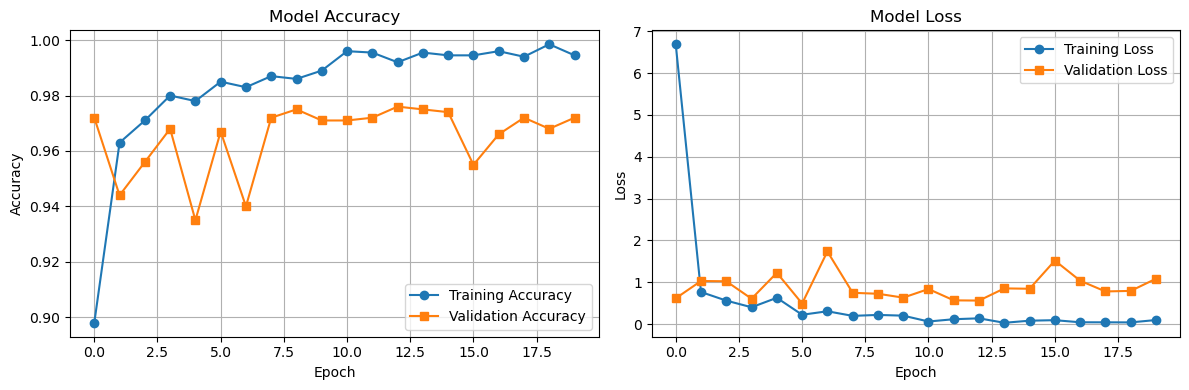

In [24]:
def plot_training_history(history):
    """
    학습 과정의 정확도와 손실을 시각화
    
    Args:
        history: model.fit()에서 반환된 History 객체
    """
    if history is None:
        print("❌ 학습 기록이 없습니다.")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # 정확도 그래프
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # 손실 그래프
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# 학습 기록이 있다면 시각화
try:
    if 'history' in locals() and history is not None:
        print("📈 학습 과정 시각화:")
        plot_training_history(history)
    else:
        print("ℹ️ 학습 기록을 시각화하려면 먼저 모델을 학습하세요.")
except:
    print("ℹ️ 학습 기록을 시각화하려면 먼저 모델을 학습하세요.")


## 8. 결론 및 다음 단계

### 완료된 작업:
✅ **Transfer Learning 구현**: VGG19 사전학습 모델 활용  
✅ **투스테이지 방식**: 특성 추출 후 분류 모델 학습  
✅ **데이터 전처리**: 체계적인 Train/Val/Test 분할  
✅ **모델 최적화**: ModelCheckpoint로 최적 모델 자동 저장  
✅ **성능 평가**: 테스트 데이터로 정확도 측정  

### Transfer Learning의 장점:
1. **빠른 학습**: CNN 부분 재사용으로 학습 시간 단축
2. **높은 성능**: 사전학습된 특성으로 좋은 성능 달성
3. **적은 데이터**: 소규모 데이터셋으로도 효과적
4. **효율성**: 제한된 컴퓨팅 자원으로도 학습 가능

### 다음 단계 제안:
1. **인라인 방식 구현**:
   - VGG19를 전체 모델에 포함하여 end-to-end 학습
   - 원본 이미지에 직접 데이터 증강 적용
   - Fine-tuning으로 VGG19 상위 레이어도 함께 학습

2. **모델 개선**:
   - 다른 사전학습 모델 시도 (ResNet, EfficientNet, MobileNet)
   - 하이퍼파라미터 최적화 (학습률, 배치 크기, 드롭아웃 비율)
   - 교차 검증으로 더 신뢰성 있는 평가

3. **고급 기법 적용**:
   - Confusion Matrix 및 분류 보고서 생성
   - Grad-CAM으로 모델 판단 근거 시각화
   - 앙상블 모델로 성능 향상

4. **실제 배포**:
   - 웹 애플리케이션으로 실시간 이미지 분류
   - REST API 서버 구축
   - 모바일 앱 연동

### 학습한 핵심 개념:
- **Transfer Learning**: 사전학습 모델 재활용
- **Feature Extraction**: CNN을 특성 추출기로 활용
- **투스테이지 vs 인라인**: 두 가지 Transfer Learning 방식
- **모델 저장/로드**: 최적 모델 관리 및 재사용
- **이진 분류**: Sigmoid 활성화와 Binary Crossentropy
